## 1: Exploratory Data Analysis (EDA)

Processo de Análise e Exploração de dados do dataset: *Credit Card Fraud Detection*.

**Link**: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

---
### 1️⃣ Importando Bibliotecas Necessárias

In [1]:
# Gerenciamento e Visualização dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")

---
### 2️⃣ Carregando os Dados

In [2]:
df = pd.read_csv("train.csv")

# Confirmando carregamento do dataset & Verificação do tamanho
train = pd.read_csv("train.csv")  
test = pd.read_csv("test.csv")

print(f"Dados de Treino: {train.shape[0]} linhas e {train.shape[1]} colunas")
print(f"Dados de Teste: {test.shape[0]} linhas e {test.shape[1]} colunas")

Dados de Treino: 227845 linhas e 32 colunas
Dados de Teste: 56962 linhas e 31 colunas


---
### 3️⃣ Análise do Dataset

In [3]:
# Verificando colunas (labels, tipos de dados, valores nulos)
print(df.info())

# Contagem de valores nulos
print(f"\nValores nulos: ", end=" ")
print(df.isnull().sum().max())

<class 'pandas.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      227845 non-null  int64  
 1   Time    227845 non-null  float64
 2   V1      227845 non-null  float64
 3   V2      227845 non-null  float64
 4   V3      227845 non-null  float64
 5   V4      227845 non-null  float64
 6   V5      227845 non-null  float64
 7   V6      227845 non-null  float64
 8   V7      227845 non-null  float64
 9   V8      227845 non-null  float64
 10  V9      227845 non-null  float64
 11  V10     227845 non-null  float64
 12  V11     227845 non-null  float64
 13  V12     227845 non-null  float64
 14  V13     227845 non-null  float64
 15  V14     227845 non-null  float64
 16  V15     227845 non-null  float64
 17  V16     227845 non-null  float64
 18  V17     227845 non-null  float64
 19  V18     227845 non-null  float64
 20  V19     227845 non-null  float64
 21  V20     227845 non-nu

---
#### 💬 Primeira Análise

| Variável | Descrição |
|----------|----------|
| *id* | ID único da transação|
| *Time* | Contagem de tempo em segundos, entre cada transação em relação à primeira transação |
| *Class* | 0 = Não Fraude, 1 = Fraude |
| *Amount* | Valor total da transação |
| *V1 - V28* | Features anônimas|

O dataset tem em sua maior parte dados de números decimais (`float`) e não possui valores ausentes, o que facilita o tratamento, pois não há necessidade de técnicas de preenchimento.

Como a coluna *Time* é dada em segundos, pode ser interessante transformar ela em ciclos de 24hrs (permite estimar horários do dia baseado na atividade de transações) para agregar maior poder preditivo.
- Com essa transformação não podemos utilizar um simples Scaler pois ele não ira compreender que na verdade 23 é próximo de 00, então usamos coordenadas circulares (Seno & Cosseno).

Observações: 
- Embora não exista valores ausentes, é preciso verificar se os valores 0 na coluna `Amount` estão corretos, ou são nulos ocultos.
- As colunas tem labels anônimos, ou seja, é preciso de fazer uma visualização estatística e de correlação com o target para entender a importância delas na previsão do modelo.

---

> Agora vamos verificar o desbalanceamento do dataset

Distribuição das Classes:

Class
0    227451
1       394
Name: count, dtype: int64

Porcentagem:

Class
0    99.827075
1     0.172925
Name: proportion, dtype: float64



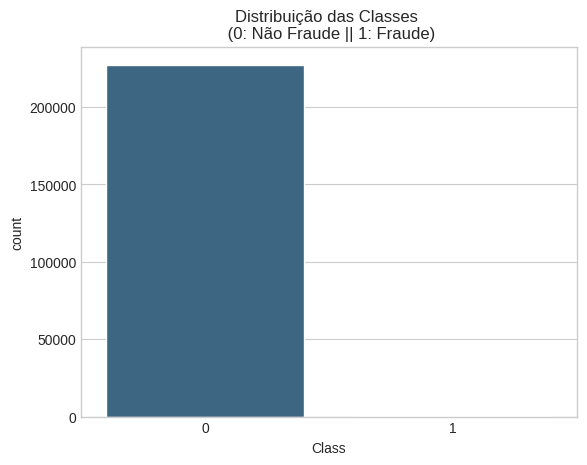

Total de transações zeradas: 1476
Fraudes entre os zeros (percentual): 1.49%


In [4]:
print(f"Distribuição das Classes:\n")
print(df["Class"].value_counts())

print("\nPorcentagem:\n")
print(f"{df["Class"].value_counts(normalize=True) * 100}\n")

# Gráfico
sns.countplot(x="Class", data=df, hue="Class", palette="viridis", legend=False)
plt.title(f"Distribuição das Classes \n (0: Não Fraude || 1: Fraude)")
plt.show()

# Contadem de valores zerados na coluna de montante da transação
zeros = df[df["Amount"] == 0]
print(f"="*30)
print(f"Total de transações zeradas: {len(zeros)}")
print(f"Fraudes entre os zeros (percentual): {(zeros["Class"].sum()/len(zeros)*100):.2f}%")

---
#### 💬 Segunda Análise

Como esperado, a fraude é um evento raro. Dessa forma, um modelo "burro" que chutassse sempre em "Não Fraude", conseguiria obter uma acurácia de 99.8% (*Paradoxo da Acurácia*), por esse motivo não podemos utilizar essa métrica como foco na avaliação do modelo.

Será necessario a utilização e comparação de técnicas que lidem com esse desbalanceamento, como *UnderSampling* e *OverSampling*.

Além disso, na verificação dos valores zerados, nota-se que essas transações zeradas não são nulas, na verdade possuem um alto poder preditivo, visto que representam uma taxa de fraude de aproximadamente 1,49%, cerca de 9 vezes maior que a taxa de fraude total do dataset de 0,17%.
- Isso sugere a criação de uma coluna adicional (`is_zero_amount`), que ao reforçar para o modelo a importância desse dado na detecção de fraudes, talvez melhore o resultao da predição, além da garantia de não perder o poder preditivo após o escalonamento da coluna `Amount`.

---

Agora vamos fazer uma transformação na coluna *Time* para ciclos de 24H (essa transformação direta será usada apenas para análise, para o treinamento a abordagem de transformação é Seno e Cosseno).

> Essa transformação, servirá para avaliar os horários de maior incidências de fraudes, que possuem uma tendência natural de acontecer com mais força no período da madrugada (01h - 05h)

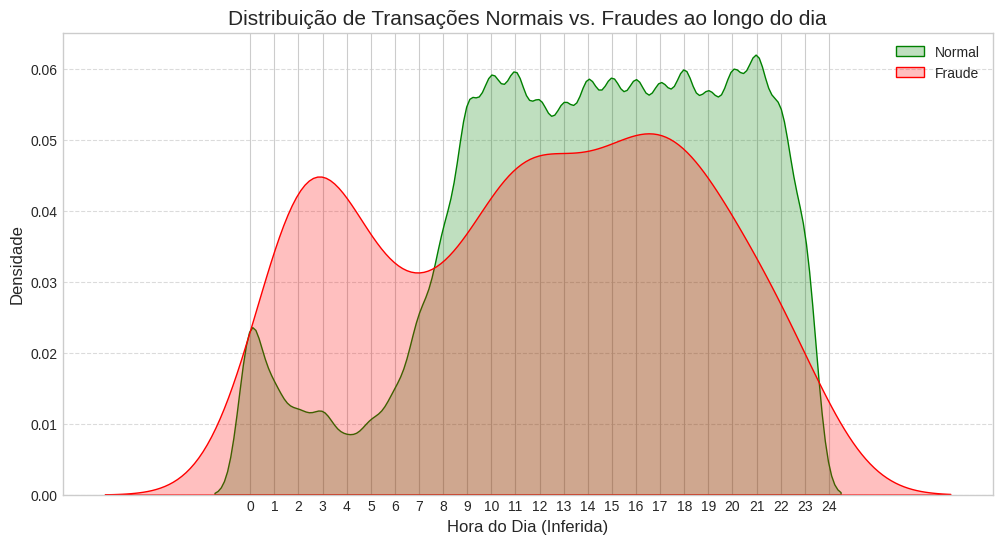

In [5]:
df["Hour"] = (df["Time"] // 3600) % 24

plt.figure(figsize=(12, 6))

# Plotando a distribuição das transações normais
sns.kdeplot(df[df["Class"] == 0]["Hour"], label="Normal", fill=True, color="g")

# Plotando a distribuição das fraudes
sns.kdeplot(df[df["Class"] == 1]["Hour"], label="Fraude", fill=True, color="r")

# Gráfico
plt.title("Distribuição de Transações Normais vs. Fraudes ao longo do dia", fontsize=15)
plt.xlabel("Hora do Dia (Inferida)", fontsize=12)
plt.ylabel("Densidade", fontsize=12)
plt.xticks(range(0, 25))
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

---
#### 💬 Terceira Análise

Como a coluna *Time* representa uma contagem linear da primeira transação em diante, não existe uma exatidão nos horários inferidos pela transformação dos segundos em horas, mas a partir da análise desse gráfico é possível obter insights interessantes.

- O horário em que os usuários legítimos dormem e existe uma menor atividade humana no gerenciamento das transações, entre 01h ás 06h comumente, é onde existe uma proporção imensamente maior entre *Fraudes* e *Não Fraudes*.

- Perceba que há um pico de *Fraudes* ás 03h (poucos usuários ativos) e uma queda brusca no período das 06h, que pode se referir ao momento que os usuários legítimos acordam e checam suas notificações.

- Durante o restante do dia, de 09h ás 21h, a proporção de *Fraude* é persistente, mas inferior as transações do dia, possivelmente tentando se camuflar entre os altos usos diários (fraco pode preditivo nesses horários).

Perceba que nos extremos do gráficos (0 e 24) as curvam realmente tendem a 0, o que demonstra uma boa correlação da contagem de segundos da coluna `Time` com o ciclo natural dos dias.

No fim, essa váriavel temporal parece possuir um bom poder preditivo quando transformada. (É necessário realizar o teste para verificar)

---

> Prosseguindo, vamos comparar a escala das colunas V com a coluna `Amount` e seus outliers

    (As colunas anônimas já estão na mesma escala, pois é informado no dataset de que elas são resultados da aplicação de PCA, que necessita desse padrão de escalonamento)

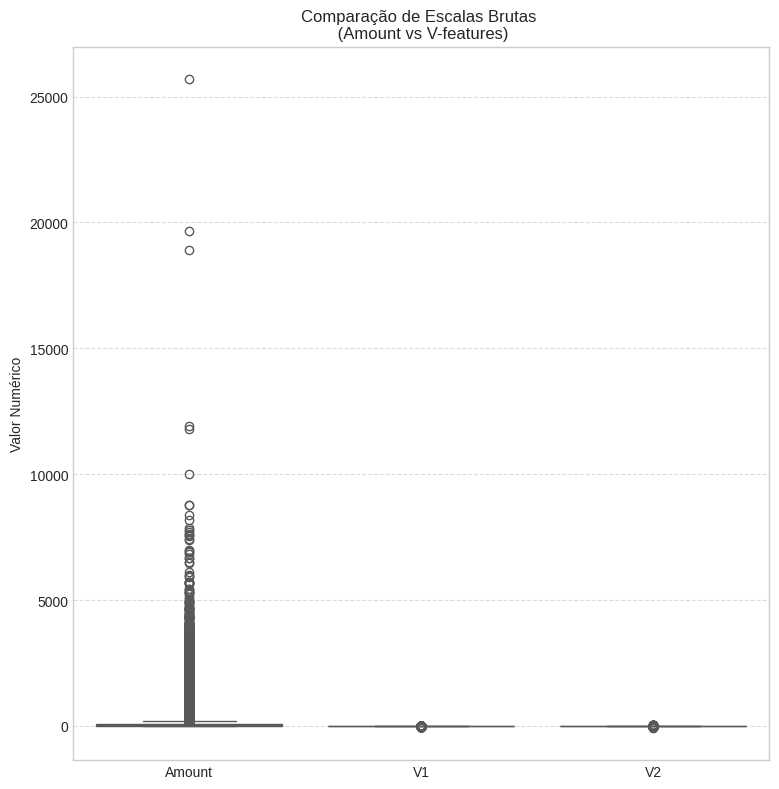

Resumo estatístico das escalas:

            Amount         V1         V2
mean     88.176298   0.000795  -0.000481
std     250.722602   1.958926   1.649092
min       0.000000 -56.407510 -72.715728
max   25691.160000   2.451888  22.057729


In [6]:
plt.figure(figsize=(15, 8))

# 1. Boxplot para comparar as escalas diretamente
plt.subplot(1, 2, 1)
sns.boxplot(data=df[["Amount", "V1", "V2"]], palette="Set2")
plt.title("Comparação de Escalas Brutas \n (Amount vs V-features)")
plt.ylabel("Valor Numérico")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

print(f"Resumo estatístico das escalas:\n")
print(df[["Amount", "V1", "V2"]].describe().loc[["mean", "std", "min", "max"]])

---
#### 💬 Quarta Análise

A partir do gráfico e do resumo estátistico, podemos confirmar que as features anônimas estão realmente na mesma escala.

Além disso, temos uma ideia sobre quão discrepante está a coluna `Amount`.

- Ela tem uma alta variação (muitos outliers), perceptível pela grande diferença entre a média e o desvio padrão, sugerindo a aplicação de um RobustScaler.

> O RobustScaler é menos sensível à influência dos outliers, pois ele não utiliza a média e o desvio padrão para fazer o escalonamento, como o StandardScaler
---

#### ⛔ Ação importante

Para prosseguir na análise do dataset, e conseguir verificar as correlações das features com a coluna "Class", precisamos criar um **Sub-Sample** que tenha um equilíbrio entre *Fraudes* & *Não Fraudes*.

Assim, podemos pegar todas as 394 fraudes e misturar com 394 não-fraudes aleatórias, e com essa amostra equilibrada, verificar as variáveis que influenciam na "Class".

> Esse subsample é para fins analíticos, não representa a forma como o modelo sera alimentado no treinamento (visto que, o modelo precida ser capaz de lidar com a realidade do desbalanceamento natural desse tipo de problema)

In [7]:
# Embaralhando para garantir aleatoridade na formação do Sub-Sample
df = df.sample(frac=1)

fraud_df = df.loc[df["Class"]==1]
non_fraud_df = df.loc[df["Class"]==0][:394]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Embaralhando novamente e verificando 50/50
new_df = normal_distributed_df.sample(frac=1, random_state=42)
print(f"Distribuição equilibrida: ", end="")
print(new_df["Class"].value_counts(normalize=True))

Distribuição equilibrida: Class
0    0.5
1    0.5
Name: proportion, dtype: float64


> Agora podemos verificar a correlação das variáveis com a coluna "Class" (Poder Preditivo)

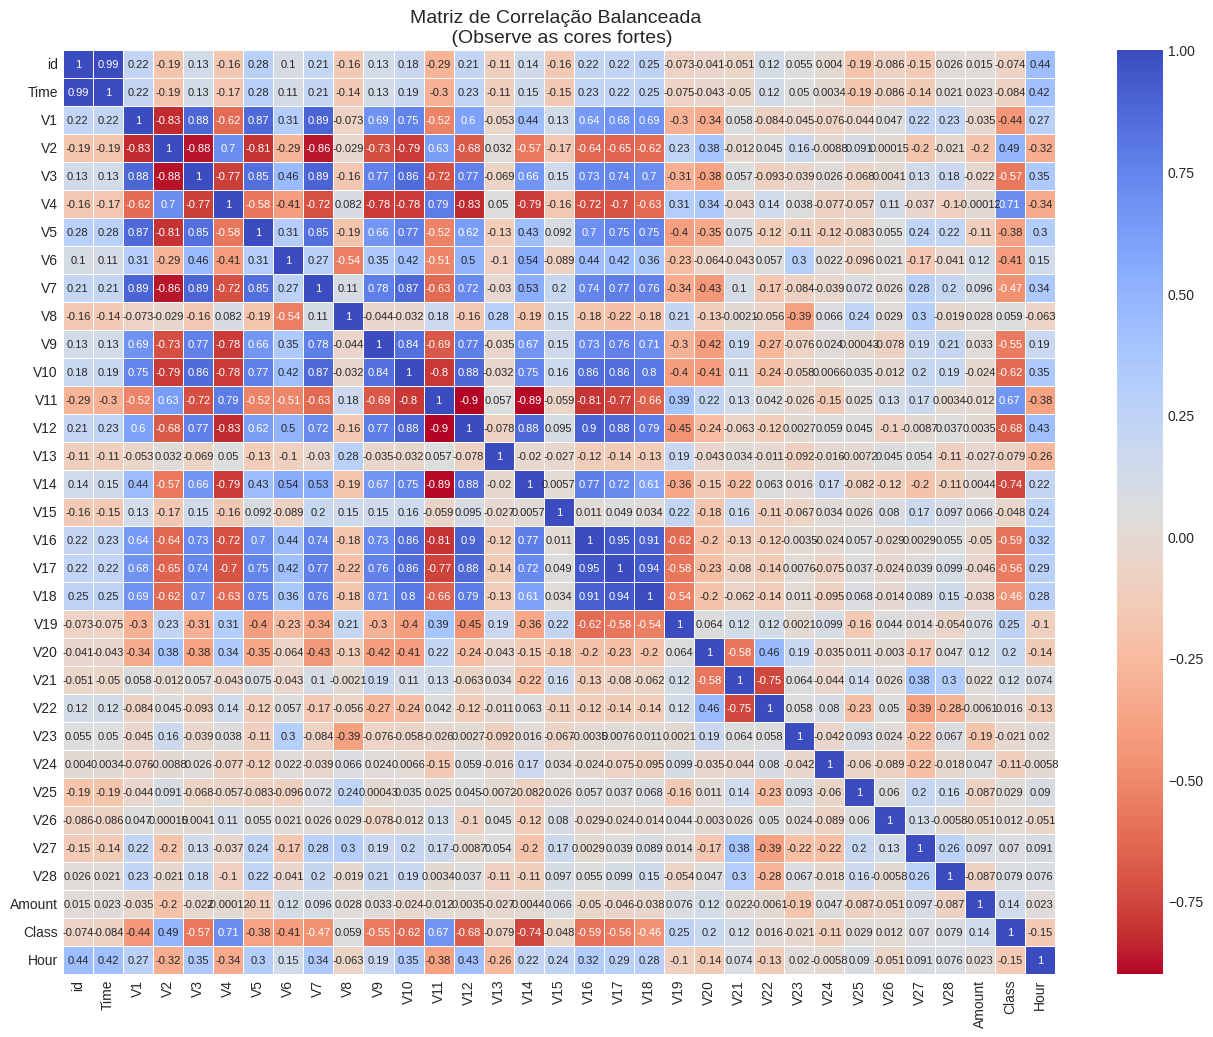

In [8]:
plt.figure(figsize=(16, 12))

"""
Caso queira visualizar como o desbalanceamento afeta as correlações
Correlação no dataset inteiro (desbalanceado)
"""
# corr = df.corr()
# sns.heatmap(corr, cmap="coolwarm_r", annot=True, annot_kws={"size":8}, linewidths=0.5)
# plt.title("Matriz de Correlação Desbalanceada \n (Não use para conclusões)", fontsize=14)

# Correlação no sub-sample (balanceado)
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap="coolwarm_r", annot=True, annot_kws={"size":8}, linewidths=0.5)
plt.title("Matriz de Correlação Balanceada \n (Observe as cores fortes)", fontsize=14)
plt.show()

---
#### 💬 Quinta Análise

A partir dessa matriz de correlações chegamos em algumas conclusões, sobre as váriaveis anônimas:

- Correlações Positivas: V2, V4, V11, V19 e V20 são as mais positivamente correlacionadas, ou seja, quanto MAIOR seus valores, maior a chance do resultado ser uma fraude.
- Correações Negativas: V3, V9, V10, V12, V14, V16 e V17 são as mais negativamente correlacionadas, ou seja, quanto MENOR seus valores, maior a chance do resultado ser uma fraude.

> Considerando variáveis com mais de 50% de correlação (positiva e negativa)

É perpetível que algumas correlações tiveram valores extremos, o que pode ser prejudicial para modelos lineares, como *Regressão Logística*.

Por um padrão conhecido, as negativas costumam vir de transações legítimas (não fraudes), por isso é preferível limpar esses pontos, como forma de reduzir **falsos positivos**.

Assim, vamos se concentrar em analisar os outliers extremos das colunas V10, V12 e V14.

> Remover todos os outliers causa uma perda de informação, que pode impactar negativamente na predição do modelo

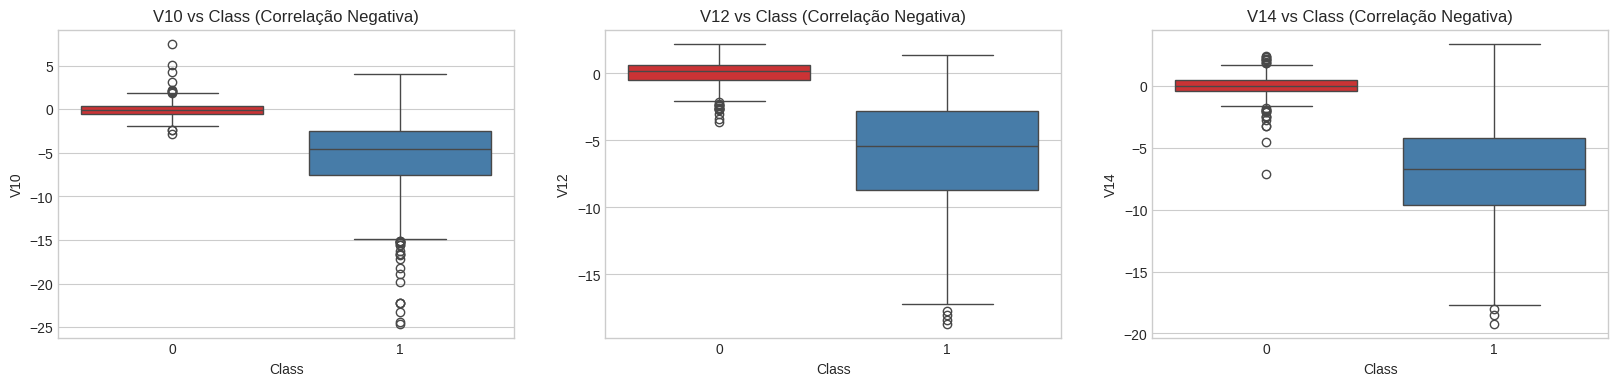

In [9]:
# Visualizando outliers com Boxplot (Exemplo com V14, V12 e V10)
f, axes = plt.subplots(ncols=3, figsize=(20,4))

sns.boxplot(x="Class", y="V10", data=new_df, hue="Class", palette="Set1", ax=axes[0], legend=False)
axes[0].set_title("V10 vs Class (Correlação Negativa)")

sns.boxplot(x="Class", y="V12", data=new_df, hue="Class", palette="Set1", ax=axes[1], legend=False)
axes[1].set_title("V12 vs Class (Correlação Negativa)")

sns.boxplot(x="Class", y="V14", data=new_df, hue="Class", palette="Set1", ax=axes[2], legend=False)
axes[2].set_title("V14 vs Class (Correlação Negativa)")

plt.show()

> Perceba que a Classe *Não Fraude* possui alguns outliers que "invadem" a região da Classe *Fraude*, assim, como tentativa para reduzir falsos positivos e melhorar a separação, podemos diminuir essas extremidades, para obter uma diferenciação mais clara entre as duas classes

Essa demonstração sugere o uso do método IQR (Interquarile Range), seguindo o padrão: $$Q1 - 1.5 \times IQR$$

- O fator de 1.5 pode ser aumentado para 3 como forma de amenizar o corte.

Focado nas features `V12` e `V14` que "invadem" mais a região da Classe *Fraude*.

Importante ressaltar, que os outliers presentes na classe *Fraude* são os mais importantes para a predição do modelo, pois costumam ser decisivos na detecção das fraudes.

Além disso, não é possível determinar que esse corte ira realmente melhorar o modelo, por isso será preciso testar durante a etapa de treinamento.

---

> Agora vamos analisar como que as classes se distribuem quando comprimidas em apenas duas dimensões

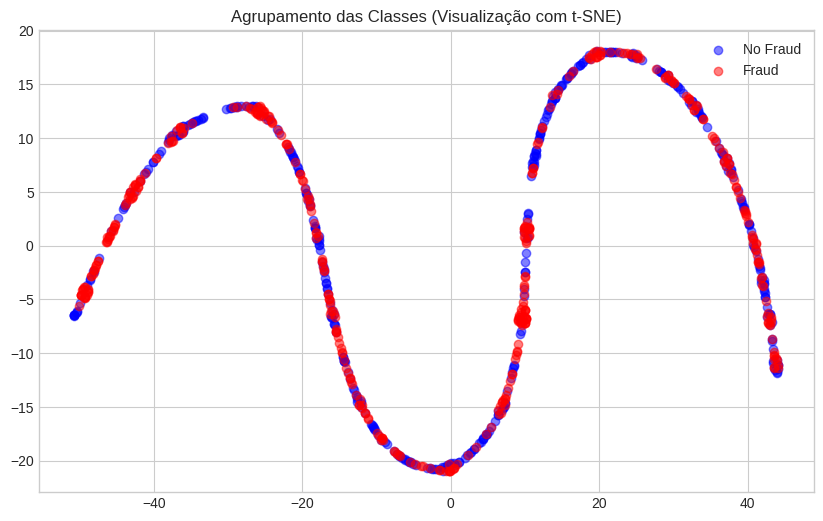

In [10]:
from sklearn.manifold import TSNE

# Usando T-SNE para visualizar como os dados se agrupam
X = new_df.drop("Class", axis=1)
y = new_df["Class"]

X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

plt.figure(figsize=(10,6))
plt.scatter(X_reduced_tsne[y == 0, 0], X_reduced_tsne[y == 0, 1], c="blue", label="No Fraud", alpha=0.5)
plt.scatter(X_reduced_tsne[y == 1, 0], X_reduced_tsne[y == 1, 1], c="red", label="Fraud", alpha=0.5)
plt.title("Agrupamento das Classes (Visualização com t-SNE)")
plt.legend()
plt.show()

---
#### 💬 Sexta Análise

Com a utilização do t-SNE, agrupamos as classes em um plano de apenas 2 dimensões, dessa forma conseguimos visualizar como que as "Fraudes" & "Não Fraudes" estão agrupadas.

Essa visualização permite entender a comparação entre as técnicas de `UnderSampling` e `OverSampling`, caso aplicadas nesse dataset.

- UnderSampling: Restringe o conjunto todos dos dados em uma pequena região (deleta maior parte dos dados). Pode auxiliar, caso o pequeno grupo seja bem representativo, como também pode fazer o modelo perder pontos de grande distinção entre as duas classes.

- OverSampling(SMOTE): Cria novos dados para a classe minoritária, reforçando a presença dessa classe. Pode auxiliar, caso os novos dados criados sejam coerentes com os dados reais, ou fazer o modelo se confundir com dados imprecisos, podendo causar muitos alarmes falsos.
    - Nessa situação onde o desbalanceameto é muito grande, utilizar o SMOTE requer atenção, para que não seja criado dados sintéticos demais e o ruído acabe por degradar o modelo.

Além disso, como a forma de disposição dos dados é complexa, existe uma tendência que modelos como *Regressão Logística* possam desempenhar mal, sendo preferíveis modelos baseado em árvores como *Random Forest* que costumam lidar melhor com essas curvas, visto que não são modelos lineares.

Por fim, o `cross-validation` se mostra muito importante visto que as classes estão muito sobrepostas, visando garantir que o modelo não está chutando (bias) ou decorando o ruído (overfitting), utilizando o *Stratified K-Fold* para garantir a proporção de *Fraudes* & *Não Fraudes* em cada dobra.

> A avaliação pelo ROC-AUC se mostra essencial, para evidenciar como o modelo separa as probabilidades entre as duas classes

---
### 🎯 Próxima Etapa

Agora finalizado o processo de EDA, vamos para a etapa de Pré-processamento & Modelagem.

Em relação as análises discutidas nesse notebook, temos as seguintes etapas para aplicar no processamento do dataset:

1. Criação da coluna `is_zero_amount`

2. Transformações circulares da coluna `Time` com Seno e Cosseno

3. Aplicação do *RobustScaler* na coluna `Amount`

4. Testar os cortes dos outliers das váriaveis `V12` & `V14`

Além disso, o modelo escolhido como baseline será o *Logistic Regression*, pela sua dificuldade natural de lidar com datasets desbalanceados. 
> O modelo principal inicial será o *Random Forest*, pela não linearidade dos modelos baseados em árvore.